# Minicompetition Project
## Rossman 6 month sales Prediction
Here, we will go through a data challenge using data predicting Sales for Rossman. 



In [1]:
import numpy as np
import pandas as pd
from pycaret.regression import *

In [5]:
train = pd.read_csv('AS24_Case_Study_Data.csv', sep=';')
train['created_date'] = pd.to_datetime(train['created_date'])
train['deleted_date'] = pd.to_datetime(train['deleted_date'])
train.drop_duplicates(inplace=True)
train.dropna(inplace=True)

train['ctr'] = train['ctr'].str.replace('.','')
train['ctr'] = train['ctr'].str[:1] + '.' + train['ctr'].str[1:]
train = train[train.ctr != "0.1 Apr"]
train['ctr'] = pd.to_numeric(train["ctr"], downcast="float")



In [13]:
train.groupby('make_name')['product_tier'].unique().reset_index()

,make_name,product_tier
0,AC,[Basic]
1,Abarth,[Basic]
2,Aixam,"[Basic, Premium]"
3,Alfa Romeo,"[Basic, Premium, Plus]"
4,Alpina,"[Basic, Plus]"
...,...,...
86,Triumph,[Basic]
87,Trucks-Lkw,[Basic]
88,Volkswagen,"[Basic, Premium, Plus]"
89,Volvo,"[Basic, Premium, Plus]"


In [6]:

product_tier_types= pd.DataFrame(train.groupby('make_name')['product_tier'].unique()).reset_index()

dataframe = pd.merge(train, product_tier_types,  how='inner', on=['make_name'])
dataframe['product_tier_y'] = dataframe['product_tier_y'].apply(lambda x: " ".join(set(x)))


In [7]:
dataframe['first_registration_year']=dataframe['first_registration_year'].apply(lambda x: 2020 - x)
dataframe['AdDuration'] = dataframe['deleted_date'] - dataframe['created_date']
dataframe['AdDuration']=dataframe['AdDuration'].apply(lambda x: float(str(x).split()[0]))
dataframe.head()

,article_id,product_tier_x,make_name,price,first_zip_digit,first_registration_year,created_date,deleted_date,search_views,detail_views,stock_days,ctr,product_tier_y,AdDuration
0,350625839,Basic,Mitsubishi,16750,5,7,2018-07-24,2018-08-24,3091.0,123.0,30,0.037803,Plus Premium Basic,31.0
1,360446382,Basic,Mitsubishi,3700,3,16,2018-12-10,2018-02-11,1301.0,54.0,21,0.041507,Plus Premium Basic,-302.0
2,355677138,Basic,Mitsubishi,5250,3,6,2018-08-28,2018-06-09,1044.0,40.0,8,0.038314,Plus Premium Basic,-80.0
3,361203412,Basic,Mitsubishi,2495,1,13,2018-10-20,2018-07-11,1381.0,173.0,18,0.125272,Plus Premium Basic,-101.0
4,355673752,Basic,Mitsubishi,7945,7,7,2018-08-28,2018-10-15,1576.0,77.0,48,0.048858,Plus Premium Basic,48.0


# 1. Initial Data Understanding
Here, we get to know our data and try to figure out next steps for modelling.

A goal in this step is to get to know what types of data cleaning, preparation and encoding we need to do in order to prepare our data for inclusion in a model.

Since we are predicting price, this is a supervised regression problem.

## visualization


In [8]:
# plot scatter carat_weight and Price
import plotly.express as px
fig = px.scatter(x=train['product_tier'], y=train['price'], 
                 facet_col = train['make_name'], opacity = 0.025, template = 'plotly_dark', trendline='ols',
                 trendline_color_override = 'red', title = 'CustomerBehavior - A CASE STUDY')
fig.show()

ValueError: Could not convert value of 'x' ('x') into a numeric type. If 'x' contains stringified dates, please convert to a datetime column.

In [ ]:
# plot histogram
fig = px.histogram(train, x=["Sales"], template = 'plotly_dark', title = 'Histogram of Sales')
fig.show()

In [ ]:
# create a copy of data
data_copy = train.copy()
# create a new feature Log_Price
data_copy['Log_Price'] = np.log(train['Sales'])
# plot histogram
fig = px.histogram(data_copy, x=["Log_Price"], title = 'Histgram of Log Price', template = 'plotly_dark')
fig.show()

## Our variables



In [5]:
# PATH to Input data
PATH_TRAIN = "data/train.csv"
PATH_TEST = "data/test.csv"
PATH_STORE = "data/store.csv"
PATH_STORE_MODIFIED = "data/store_modified.csv"
MODEL_NAME = "XGBoostBasic.txt"
LABEL_ENCODE="LabelEncode"
TARGET_ENCODE="TargetEncode"
COLUMNS_NAME = "Columns_name"

## functions for wrangling and cleaning our data

In [11]:

def store_preprocess(storefile):
    # reading store_id file
    store = pd.read_csv(storefile)
    # Creating columns of competition and Promo2history with total period in months, and weeks
    store['CompetitionPeriod'] = (12-store.CompetitionOpenSinceMonth) + ((2015-store.CompetitionOpenSinceYear)*12)
    store['Promo2history'] = (52-store.Promo2SinceWeek) + ((2015-store.Promo2SinceYear)*52)
    # Dropping unnecessary columns
    store.drop(columns=['CompetitionOpenSinceMonth','CompetitionOpenSinceYear','Promo2SinceWeek', 'Promo2SinceYear'], inplace=True)
    return store

def data_preprocess(df, trainpath, store):
    # reading trainpath file
    dataframe = pd.read_csv(df)
    dataframe.replace({"StateHoliday": {0:'0'}}, inplace=True)
    # Exctraction of month and year columns in the dataframe
    def date_extraction(dataset):
            dataset['Date'] = pd.to_datetime(dataset['Date'])
            dataset['year'] = pd.DatetimeIndex(dataset['Date']).year
            dataset['month'] = pd.DatetimeIndex(dataset['Date']).month
            dataset['Day'] = dataset.Date.dt.day
            dataset['DayOfWeek'] = dataset.Date.dt.dayofweek
            dataset['WeekOfYear'] = dataset.Date.dt.weekofyear
    date_extraction(dataframe)

    # reading trainpath file
    train = pd.read_csv(trainpath)
    train.replace({"StateHoliday": {0:'0'}}, inplace=True)
    # Exctraction of month and year columns in trainpath file
    date_extraction(train)
    # Feature extraction of average customers per store, and average sales per store.
    groupy = train.groupby(['Store','month'])['Customers','Sales'].mean().rename(columns={'Customers':'CustomersAvg', 'Sales':'SalesAvg'}).reset_index()    
    # Adding feature extraction to our dataframe
    dataframe = pd.merge(dataframe, groupy,  how='inner', on=['Store','month'])
    dataframe = pd.merge(dataframe, store,  how='inner', on=['Store'])
    # Dropping unnecessary columns
    if 'Customers' in dataframe.columns:
        dataframe.drop(columns= 'Customers', inplace=True)
    dataframe.loc[:,['Promo2history']]= dataframe.loc[:,['Promo2history']].fillna(0)
    dataframe.loc[:,['CompetitionPeriod']]= dataframe.loc[:,['CompetitionPeriod']].fillna(1400)
    dataframe.loc[:,'PromoInterval']= dataframe.loc[:,'PromoInterval'].fillna('na')
    dataframe.loc[:,'CompetitionDistance']= dataframe.loc[:,'CompetitionDistance'].fillna(dataframe.CompetitionDistance.max())
    if 'Sales' in dataframe.columns:
        dataframe=dataframe.loc[dataframe['Sales']!=0]
    return dataframe



### running preprocessing on our data

In [12]:
store = store_preprocess(PATH_STORE)
train = data_preprocess(PATH_TRAIN, PATH_TRAIN, store)
holdout = data_preprocess(PATH_TEST, PATH_TRAIN, store)


store.to_csv('data/store_clean.csv')
train.to_csv('data/train_clean.csv')
holdout.to_csv('data/holdout_clean.csv')

# Model pipeline


In [10]:
from pycaret.classification import *
# initialize setup
s = setup(data = dataframe, session_id=42,
             train_size = 0.80,
             target = 'product_tier_x', 
            #  fold_strategy = 'timeseries', 
            numeric_features = ['AdDuration'], 
            ignore_features= ['article_id'],
            #  categorical_features=['PromoInterval', 'Assortment', 'StoreType',  'StateHoliday'],
             fold = 3, transformation = True, 
            #  high_cardinality_features = ['make_name'],
             numeric_imputation = 'median', categorical_imputation = "constant", feature_selection = False,
             normalize = True,  
             fix_imbalance = True, 
             ignore_low_variance = True, remove_multicollinearity = True, 
             multicollinearity_threshold = 0.80, 
             remove_outliers=True)

,Description,Value
0,session_id,42
1,Target,product_tier_x
2,Target Type,Multiclass
3,Label Encoded,"Basic: 0, Plus: 1, Premium: 2"
4,Original Data,"(78296, 14)"
5,Missing Values,False
6,Numeric Features,7
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [11]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.9742,0.9517,0.5393,0.9686,0.9704,0.5717,0.5820,111.8700
xgboost,Extreme Gradient Boosting,0.9731,0.9460,0.5296,0.9671,0.9691,0.5496,0.5605,76.2033
lightgbm,Light Gradient Boosting Machine,0.9717,0.9473,0.5412,0.9667,0.9685,0.5526,0.5573,5.9633
rf,Random Forest Classifier,0.9688,0.9277,0.4260,0.9609,0.9599,0.3325,0.3973,15.4400
et,Extra Trees Classifier,0.9669,0.9166,0.4044,0.9567,0.9566,0.2591,0.3312,17.2600
dummy,Dummy Classifier,0.9634,0.5000,0.3333,0.9282,0.9455,0.0000,0.0000,0.4333
gbc,Gradient Boosting Classifier,0.9381,0.9392,0.6173,0.9650,0.9492,0.4240,0.4549,96.3733
dt,Decision Tree Classifier,0.9347,0.7347,0.5294,0.9550,0.9439,0.3216,0.3351,4.0900
ada,Ada Boost Classifier,0.8740,0.9060,0.6176,0.9621,0.9116,0.2536,0.3204,7.1633
knn,K Neighbors Classifier,0.8412,0.8394,0.5767,0.9567,0.8894,0.1887,0.2561,158.3367


In [14]:
catboost_reg = create_model('catboost', fold = 10)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9741,0.9514,0.5603,0.9704,0.9709,0.5883,0.5939
1,0.9753,0.9557,0.5461,0.9678,0.9715,0.6020,0.6092
2,0.9745,0.9532,0.5538,0.9699,0.9711,0.5885,0.5955
3,0.9740,0.9509,0.5521,0.9688,0.9708,0.5763,0.5842
4,0.9739,0.9520,0.5563,0.9701,0.9708,0.5815,0.5876
5,0.9745,0.9640,0.5509,0.9698,0.9710,0.5734,0.5842
6,0.9741,0.9487,0.5290,0.9668,0.9702,0.5678,0.5784
7,0.9766,0.9591,0.5512,0.9723,0.9729,0.6068,0.6194
8,0.9723,0.9551,0.5271,0.9678,0.9684,0.5452,0.5531
9,0.9733,0.9491,0.5282,0.9668,0.9695,0.5573,0.5673


In [17]:
catboost_reg = finalize_model(catboost_reg)
save_model(catboost_reg, '2022-01-02-catboost_tier_class')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['article_id'],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=['AdDuration'],
                                       target='product_tier_x',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_va...
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'),
                 ('fix_multi',
                  Fix_multicollinearity(correlation_with_target_preference=None,
           

# Feature importance


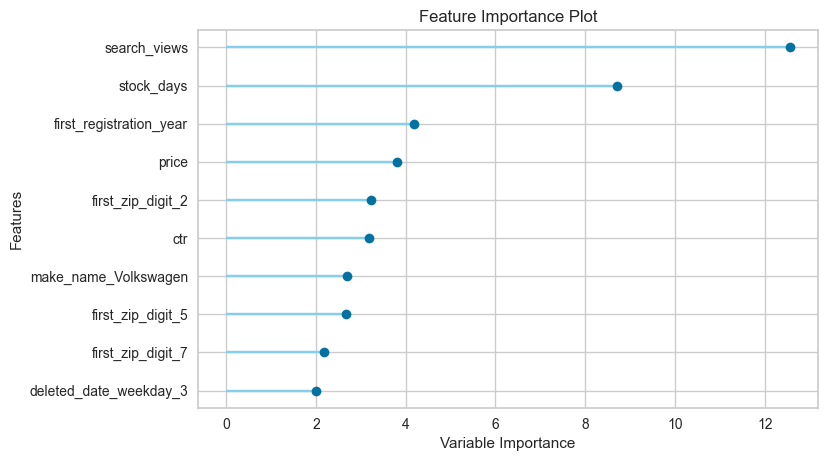

In [18]:
plot_model(catboost_reg, 'feature')